# **Data Integration and Visualization of Team Metrics: A Comprehensive Overview**


Utilizing the effectiveness of Apache Spark in Python, this notebook conducts a comprehensive analysis of the given dataset, providing an in-depth exploration into different aspects of team dynamics.

In our pursuit of visualizing team data, a meticulous series of joins was executed, leveraging various datasets to extract essential information. Our primary objective was to amalgamate pertinent details from "team-assignments.csv," "ad-clicks.csv," "game-clicks.csv," and "buy-clicks.csv." The sequential joins allowed us to compile a comprehensive dataset, encompassing Ad_Count, Hit_Count, Purchase_Count, Total_Purchase, and strength information from the respective sources.

The amalgamation process involved linking "team-assignments.csv" with "ad-clicks.csv" to extract Ad_Count data. Subsequently, we merged this dataset with "game-clicks.csv" to capture the Hit_Count records. Further, the inclusion of "buy-clicks.csv" facilitated the extraction of Purchase_Count and Total_Purchase amount data. Finally, a join with "team.csv" provided the crucial strength information.



In [ ]:
!apt-get install openjdk-8-jdk-headless

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("DataCleaningApp")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

In [ ]:
#loadining dataset
from pyspark.sql.functions import isnan, when, count, col , desc
from pyspark.sql.functions import year, month, date_format ,hour , dayofweek
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

team_ass_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/team-assignments.csv")

ad_clicks_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/ad-clicks.csv")

game_click_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/game-clicks.csv")

buy_click_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/buy-clicks.csv")

team_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/team.csv")

users_df = spark.read.format("csv").option("header", "true").load("/content/sample_data/users.csv")

In [ ]:
# Rename the 'team' column to 'teamId' in the team_ass_df DataFrame
team_ass_df = team_ass_df.withColumnRenamed('team', 'teamId')

# Convert 'teamId' and 'userId' columns in game_click_df to integers
game_click_df = game_click_df.withColumn("teamId", col("teamId").cast("integer"))
game_click_df = game_click_df.withColumn("userId", col("userId").cast("integer"))

# Convert 'teamId' and 'userId' columns in team_ass_df to integers
team_ass_df = team_ass_df.withColumn("teamId", col("teamId").cast("integer"))
team_ass_df = team_ass_df.withColumn("userId", col("userId").cast("integer"))

# Filter game_click_df to include only rows where 'isHit' is True, then group by 'userId' and 'teamId' and count hits
hit_count = game_click_df.filter(col("isHit") == True).groupBy("userId", "teamId").agg(count("*").alias("Hit_Count"))

# Join team_ass_df with hit_count based on 'teamId' and 'userId', using a left outer join
team_ass_with_count_hit = team_ass_df.join(hit_count, on=['teamId', 'userId'], how='left_outer')


In [ ]:
# Convert 'teamId', 'userId', and 'adId' columns in ad_clicks_df to integers
ad_clicks_df = ad_clicks_df.withColumn("teamId", col("teamId").cast("integer"))
ad_clicks_df = ad_clicks_df.withColumn("userId", col("userId").cast("integer"))
ad_clicks_df = ad_clicks_df.withColumn("adId", col("adId").cast("integer"))

# Calculate ad counts by grouping ad_clicks_df by 'teamId' and 'userId'
ad_counts = ad_clicks_df.groupBy(['teamId', 'userId']).agg(count('adId').alias('Ad_Count'))

# Join team_ass_with_count_hit with ad_counts based on 'teamId' and 'userId', using a left outer join
team_ass_with_count_ad = team_ass_with_count_hit.join(ad_counts, on=['teamId', 'userId'], how='left_outer')

# Display summary statistics for the resulting dataframe
team_ass_with_count_ad.describe().toPandas().transpose()



,0,1,2,3,4
summary,count,mean,stddev,min,max
teamId,9826,87.46468552819051,43.42936266588799,2,184
userId,9826,1209.5669651943822,689.1245775643522,0,2392
timestamp,9826,None,None,2016-05-26 14:06:54,2016-06-16 11:06:54
assignmentId,9826,18491.93018522288,9883.61709631016,10058,9653
Hit_Count,1212,69.35808580858085,65.09915317913158,1,517
Ad_Count,613,26.99347471451876,15.999488038115274,1,67


In [ ]:
# Rename the 'team' column to 'teamId' in buy_click_df DataFrame
buy_click_df = buy_click_df.withColumnRenamed('team', 'teamId')

# Convert 'teamId', 'userId', and 'price' columns in buy_click_df to appropriate data types
buy_click_df = buy_click_df.withColumn("teamId", col("teamId").cast("integer"))
buy_click_df = buy_click_df.withColumn("userId", col("userId").cast("integer"))
buy_click_df = buy_click_df.withColumn("price", col("price").cast("float"))

# Calculate Total Purchase and Purchase Count by grouping buy_click_df by 'teamId' and 'userId'
buy_count = buy_click_df.groupBy(["teamId", "userId"]).agg({"buyid": "count", "price": "sum"})

# Join team_ass_with_count_ad with buy_count based on 'teamId' and 'userId', using a left outer join
team_ass_with_count_buy = team_ass_with_count_ad.join(buy_count, on=['teamId', 'userId'], how='left_outer')

# Rename the columns for clarity
team_ass_with_count_buy = team_ass_with_count_buy.withColumnRenamed('sum(price)', 'Total_Purchase')
team_ass_with_count_buy = team_ass_with_count_buy.withColumnRenamed('count(buyid)', 'Purchase_Count')

# Display the first 5 rows of the resulting dataframe
team_ass_with_count_buy.show(5)

# Display summary statistics for the resulting dataframe
team_ass_with_count_buy.describe().toPandas().transpose()


+------+------+-------------------+------------+---------+--------+---------------+---------------+
|teamId|userId|          timestamp|assignmentId|Hit_Count|Ad_Count|Total_Puarchase|Puarchase_Count|
+------+------+-------------------+------------+---------+--------+---------------+---------------+
|    64|   504|2016-05-26 14:06:54|        5439|       58|      43|           65.0|              7|
|    39|  1698|2016-05-26 14:07:00|        5301|     null|    null|           null|           null|
|    85|    81|2016-05-26 14:07:04|        5540|       90|    null|           null|           null|
|    95|  1976|2016-05-26 14:07:08|        5307|     null|    null|           null|           null|
|    97|  1009|2016-05-26 14:07:09|        5368|     null|    null|           null|           null|
+------+------+-------------------+------------+---------+--------+---------------+---------------+
only showing top 5 rows



,0,1,2,3,4
summary,count,mean,stddev,min,max
teamId,9826,87.46468552819051,43.42936266588799,2,184
userId,9826,1209.5669651943822,689.1245775643522,0,2392
timestamp,9826,None,None,2016-05-26 14:06:54,2016-06-16 11:06:54
assignmentId,9826,18491.93018522288,9883.61709631016,10058,9653
Hit_Count,1212,69.35808580858085,65.09915317913158,1,517
Ad_Count,613,26.99347471451876,15.999488038115274,1,67
Total_Puarchase,560,38.714285714285715,40.88266481207495,1.0,223.0
Puarchase_Count,560,5.330357142857143,3.247645060823888,1,16


In [ ]:
# Join team_ass_with_count_buy with team dataset based on 'teamId', using a left outer join
joined_data = team_ass_with_count_buy.join(team_df, on=['teamId'], how='left_outer')

# Select necessary columns from the joined_data
final_data = joined_data.select('userId', 'teamId', 'Hit_Count', 'Ad_Count', 'Puarchase_Count', 'Total_Puarchase', 'strength')

# Display the selected columns in the final_data DataFrame
final_data.show()

# Display summary statistics for the selected columns in the final_data DataFrame
final_data.describe().toPandas().transpose()


+------+------+---------+--------+---------------+---------------+---------------+
|userId|teamId|Hit_Count|Ad_Count|Puarchase_Count|Total_Puarchase|       strength|
+------+------+---------+--------+---------------+---------------+---------------+
|   504|    64|       58|      43|              7|           65.0| 0.406089913506|
|  1698|    39|     null|    null|           null|           null| 0.718462485619|
|    81|    85|       90|    null|           null|           null| 0.132214897776|
|  1976|    95|     null|    null|           null|           null| 0.701621474289|
|  1009|    97|     null|    null|           null|           null| 0.340788463107|
|  1208|    39|     null|    null|           null|           null| 0.718462485619|
|  1665|    70|       95|    null|           null|           null| 0.393763462002|
|   665|    18|     null|    null|           null|           null| 0.885469892018|
|  1962|    44|     null|    null|           null|           null| 0.767191204445|
|   

,0,1,2,3,4
summary,count,mean,stddev,min,max
userId,9826,1209.5669651943822,689.1245775643522,0,2392
teamId,9826,87.46468552819051,43.42936266588799,2,184
Hit_Count,1212,69.35808580858085,65.09915317913158,1,517
Ad_Count,613,26.99347471451876,15.999488038115274,1,67
Puarchase_Count,560,5.330357142857143,3.247645060823888,1,16
Total_Puarchase,560,38.714285714285715,40.88266481207495,1.0,223.0
strength,5690,0.5243088037392576,0.283135090504863,0.0132752022046,0.994851162257


In [ ]:
# checkin null values
final_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in final_data.columns]).show()

# Checking Duplicat Values
df_duplicates = final_data.groupBy(final_data.columns).count().filter(col("count")>1)
df_duplicates.show()

# removing duplicate rows
final_data_clean = final_data.dropDuplicates(subset=["userId", "teamId", "Hit_count", "Ad_Count", "Puarchase_Count","Total_Puarchase", "strength"])


final_data_clean.filter(final_data_clean.userId == 1472).show()


+------+------+---------+--------+---------------+---------------+--------+
|userId|teamId|Hit_Count|Ad_Count|Puarchase_Count|Total_Puarchase|strength|
+------+------+---------+--------+---------------+---------------+--------+
|     0|     0|     8614|    9213|           9266|           9266|    4136|
+------+------+---------+--------+---------------+---------------+--------+

+------+------+---------+--------+---------------+---------------+---------------+-----+
|userId|teamId|Hit_Count|Ad_Count|Puarchase_Count|Total_Puarchase|       strength|count|
+------+------+---------+--------+---------------+---------------+---------------+-----+
|  1496|    36|       12|       7|              2|            5.0| 0.642122051019|    2|
|  1257|   115|     null|    null|           null|           null|           null|    2|
|  1549|    78|     null|    null|           null|           null| 0.796923109534|    2|
|  1056|    27|     null|    null|           null|           null| 0.141376627543|   

It's essential to note that only teams exhibiting activity across all columns were selected for inclusion. The resultant data set showcases a comprehensive summary of their performance. Noteworthy statistics include a maximum Hit_Count of 517, the highest Total_Purchase amount reaching 223, and a peak Ad_Count of 67.

This comprehensive data integration and visualization process offer a profound insight into the performance metrics of teams, providing a solid foundation for further analysis and decision-making.





In [ ]:
# Filter final_data_clean to include only rows with positive Total_Puarchase, Hit_Count, and Ad_Count
team_data = final_data_clean.where((final_data_clean.Total_Puarchase > 0) & (final_data_clean.Hit_Count > 0) & (final_data_clean.Ad_Count > 0))

# Display summary statistics for the chosen active users in the team_data DataFrame
team_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
userId,544,1216.6544117647059,684.2162849185333,1,2387
teamId,544,79.75735294117646,43.22415706877513,2,178
Hit_Count,544,80.42463235294117,69.40853660627107,1,517
Ad_Count,544,29.303308823529413,15.25854251842517,1,67
Puarchase_Count,544,5.4099264705882355,3.2472077244354405,1,16
Total_Puarchase,544,39.27757352941177,41.21450616259556,1.0,223.0
strength,361,0.5130508237622582,0.28530313024638077,0.0132752022046,0.952175553216


+------+--------------------+
|teamId|sum(Total_Puarchase)|
+------+--------------------+
|    27|               880.0|
|    54|               777.0|
|    35|               710.0|
|    64|               693.0|
|    53|               677.0|
|    66|               647.0|
|    59|               644.0|
|    11|               587.0|
|    97|               549.0|
|    22|               535.0|
+------+--------------------+



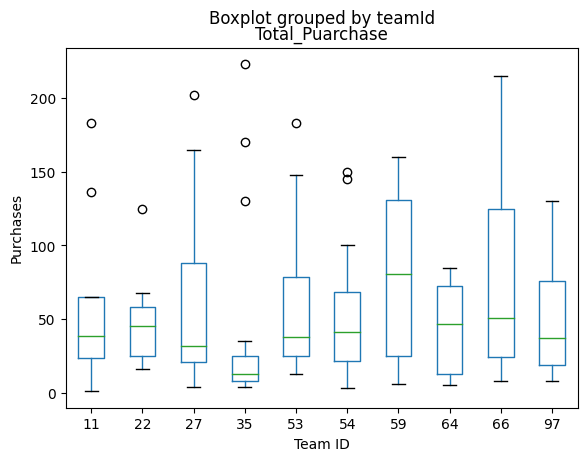

In [ ]:
# Aggregate the total_price column by team
# Group by 'teamId', calculate the sum of 'Total_Puarchase', and sort in descending order
top_10_users = team_data.groupby('teamId').agg({'Total_Puarchase': 'sum'}).sort(desc('sum(Total_Puarchase)')).limit(10)

# Display the top 10 teams with their aggregated 'Total_Puarchase'
top_10_users.show()

# Specify the team IDs for which boxplots will be created
team_ids = [27, 54, 35, 64, 53, 66, 59, 11, 97, 22]

# Filter the team_data to only include rows with the specified team IDs and select relevant columns
selected_data = team_data.filter(team_data.teamId.isin(team_ids)).select('teamId', 'Total_Puarchase')

# Convert the selected data to a Pandas DataFrame for plotting
final_data_df = selected_data.toPandas()

# Create a boxplot by 'teamId' for the 'Total_Puarchase' column
final_data_df.boxplot(by='teamId', column=['Total_Puarchase'], grid=False)

# Set the labels for the x and y axes
plt.xlabel('Team ID')
plt.ylabel('Purchases')

# Display the boxplot
plt.show()


+------+-------------+
|teamId|sum(Ad_Count)|
+------+-------------+
|    64|          681|
|    35|          623|
|    27|          554|
|    54|          473|
|    22|          462|
|    53|          431|
|     9|          426|
|    18|          426|
|    72|          403|
|    51|          402|
+------+-------------+



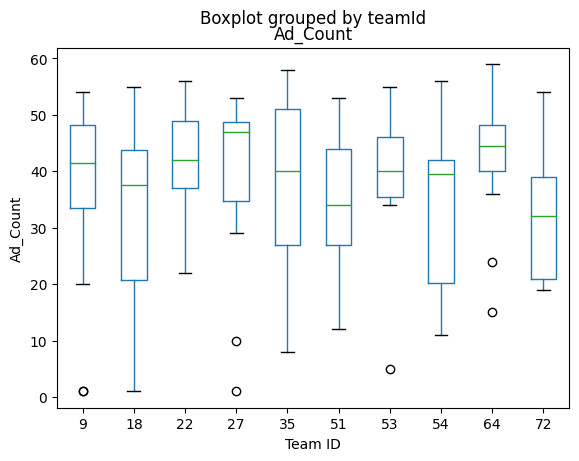

In [ ]:
# Aggregate the ad_count column by team
# Group by 'teamId', calculate the sum of 'Ad_Count', and sort in descending order
top_10_users = team_data.groupby('teamId').agg({'Ad_Count': 'sum'}).sort(desc('sum(Ad_Count)')).limit(10)

# Display the top 10 teams with their aggregated 'Ad_Count'
top_10_users.show()

# Specify the team IDs for which boxplots will be created
team_ids = [64, 35, 27, 54, 22, 53, 9, 18, 72, 51]

# Filter the final_data to only include rows with the specified team IDs and select relevant columns
selected_data = final_data.filter(final_data.teamId.isin(team_ids)).select('teamId', 'Ad_Count')

# Convert the selected data to a Pandas DataFrame for plotting
final_data_df = selected_data.toPandas()

# Create a boxplot by 'teamId' for the 'Ad_Count' column
final_data_df.boxplot(by='teamId', column=['Ad_Count'], grid=False)

# Set the labels for the x and y axes
plt.xlabel('Team ID')
plt.ylabel('Ad_Count')

# Display the boxplot
plt.show()


+------+--------------+
|teamId|sum(Hit_Count)|
+------+--------------+
|    94|           954|
|    54|           829|
|    27|           769|
|    35|           763|
|    64|           759|
|    51|           744|
|    59|           742|
|   111|           712|
|    32|           709|
|    11|           704|
+------+--------------+



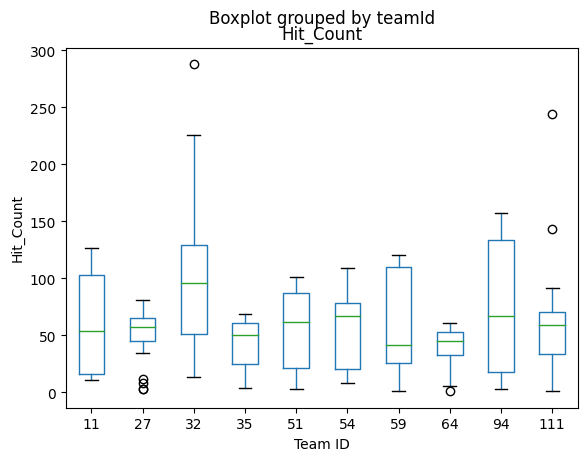

In [ ]:
# Aggregate the Hit_Count column by team
# Group by 'teamId', calculate the sum of 'Hit_Count', and sort in descending order
top_10_users = team_data.groupby('teamId').agg({'Hit_Count': 'sum'}).sort(desc('sum(Hit_Count)')).limit(10)

# Display the top 10 teams with their aggregated 'Hit_Count'
top_10_users.show()

# Define the team IDs for which you want to create boxplots
team_ids = [94, 54, 27, 35, 64, 51, 59, 111, 32, 11]

# Filter the final_data to only include rows with the specified team IDs and select relevant columns
selected_data = final_data.filter(final_data.teamId.isin(team_ids)).select('teamId', 'Hit_Count')

# Convert the selected data to a Pandas DataFrame for plotting
final_data_df = selected_data.toPandas()

# Create a boxplot by 'teamId' for the 'Hit_Count' column
final_data_df.boxplot(by='teamId', column=['Hit_Count'], grid=False)

# Set the labels for the x and y axes
plt.xlabel('Team ID')
plt.ylabel('Hit_Count')

# Display the boxplot
plt.show()


+------+--------------------+
|teamId|sum(Puarchase_Count)|
+------+--------------------+
|    27|                 101|
|    64|                 100|
|     9|                  98|
|    35|                  94|
|    54|                  89|
|    72|                  88|
|    53|                  86|
|    22|                  86|
|    99|                  79|
|    66|                  79|
+------+--------------------+



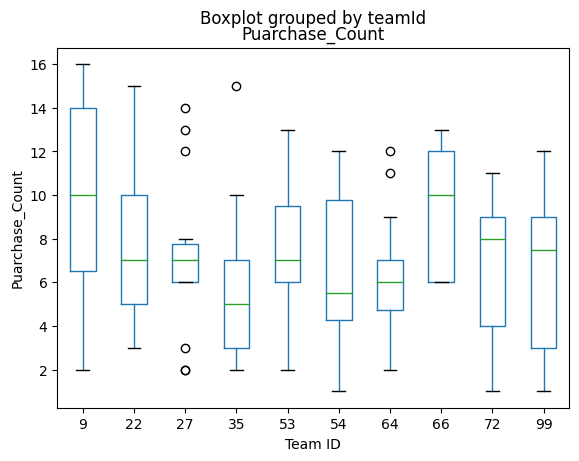

In [ ]:
# Aggregate the Purchase_Count column by team
# Group by 'teamId', calculate the sum of 'Puarchase_Count', and sort in descending order
top_10_users = team_data.groupby('teamId').agg({'Puarchase_Count': 'sum'}).sort(desc('sum(Puarchase_Count)')).limit(10)

# Display the top 10 teams with their aggregated 'Puarchase_Count'
top_10_users.show()

# Define the team IDs for which you want to create boxplots
team_ids = [27, 64, 9, 35, 54, 72, 53, 22, 99, 66]

# Filter the final_data to only include rows with the specified team IDs and select relevant columns
selected_data = final_data.filter(final_data.teamId.isin(team_ids)).select('teamId', 'Puarchase_Count')

# Convert the selected data to a Pandas DataFrame for plotting
final_data_df = selected_data.toPandas()

# Create a boxplot by 'teamId' for the 'Puarchase_Count' column
final_data_df.boxplot(by='teamId', column=['Puarchase_Count'], grid=False)

# Set the labels for the x and y axes
plt.xlabel('Team ID')
plt.ylabel('Puarchase_Count')

# Display the boxplot
plt.show()


In [ ]:
# Aggregate the strenght by  team
top_10_users = team_data.groupby('teamId').agg({'strength': 'sum'}).sort(desc('sum(strength)')).limit(10)
top_10_users.show()

+------+------------------+
|teamId|     sum(strength)|
+------+------------------+
|    35|14.213045409832002|
|    99|10.716647072111998|
|    18|10.625638704215996|
|     9| 9.521755532159998|
|    13|    7.970987406573|
|    94| 7.655487321759998|
|    51| 7.303832797199998|
|    25| 7.156228596375998|
|    77| 7.144555441373999|
|    64| 6.497438616096002|
+------+------------------+



In [ ]:
# Aggregate the strenght by  team
top_10_users = team_data.groupby('teamId').agg({'userId': 'count'}).sort(desc('count(userId)')).limit(10)
top_10_users.show()

+------+-------------+
|teamId|count(userId)|
+------+-------------+
|    35|           17|
|    64|           16|
|    27|           14|
|    54|           14|
|    72|           13|
|    51|           12|
|    99|           12|
|    18|           12|
|    53|           11|
|    22|           11|
+------+-------------+

